# Content Analysis Analysis

1. Basic stats re the qualitative coding

In [1]:
from tqdm.auto import tqdm 
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

sns.set_style("whitegrid",{'axes.spines.left' : False,
                           'axes.spines.right': False,
                           'axes.spines.top': False,
                           'grid.linestyle': ':'})
sns.set_context("talk")

## Cohen’s Kappa

> After collecting the twitter threads for each rumour, I coded each tweet according to whether it affirms, denies, is neutral towards, or questions the rumour, with a fith category for irrelvant tweets or tweets that would not have sufficient context to be understood by the experiment's participants. After coding the rumour dataset twice, with a week in between each coding session, I achieved a high degree of internal consitency (Cohen's $\kappa=0.768$). Conflicting codes were resolved in a third coding session and tweets coded as irrelevant ($N=1377$) were discarded -- leaving 167 remaining tweets to be used in the experimental environment.

Coding reliability

Used for measuring the internal reliability of categorical data.

See [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) for code, [Measuring Agreement: Kappa](https://www.sheffield.ac.uk/polopoly_fs/1.885169!/file/88_Kappa.pdf) for overview, and [Guidelines for Reporting Reliability and Agreement Studies (GRRAS)were proposed](https://www.acilci.net/wp-content/uploads/2014/02/Guidelines-for-reporting-reliability-and-agreement-studies-GRRAS-were-proposed.pdf) for an indepth look.


In [2]:
from sklearn.metrics import cohen_kappa_score
coded = {
    'kidnapping': glob("../data/processed/coded-kidnapping-*.csv"),
    'contact_tracing': glob("../data/processed/coded-contact_tracing-*.csv")
}
codes1,codes2 = np.array([]),np.array([])
for key,fps in coded.items():
    assert len(fps) == 2, "Extra filepaths (requires 2)"
    df1,df2 = (pd.read_csv(fp) for fp in fps)
    new_codes1,new_codes2 = df1['code'].to_numpy(),df2['code'].to_numpy()
    codes1 = np.concatenate((codes1, new_codes1))
    codes2 = np.concatenate((codes2, new_codes2))

cohen_kappa_score(codes1,codes2)

0.7683841783558454

### Drop Irrelevant Tweets

In [4]:
codebook = {
    0: "Irrelevant/Spam",
    1: "Affirms",
    2: "Denies",
    3: "Neutral",
    4: "Questions",
    'R1': "Kidnapping Rumour (R1, High Evidence)",
    'R2': "Contact Tracing Rumour (R2, Low Evidence)",
}

evidence = {
    'R1': "High",
    'R2': "Low"
}

In [5]:
csvs = glob("../data/processed/FINAL-*.csv")
frames = [pd.read_csv(fp) for fp in csvs]
coded_tweets = pd.concat(frames, axis=0, ignore_index=True)
coded_tweets['rumour_label'] = coded_tweets['rumour'].map(codebook)
coded_tweets['code_label'] = coded_tweets['final_code'].map(codebook)
coded_tweets['evidence'] = coded_tweets['rumour'].map(evidence)
print("{}x{}".format(*coded_tweets.shape))
og_len = len(coded_tweets)

1544x12


In [6]:
coded_tweets = coded_tweets[coded_tweets['final_code'] > 0]
print(f"Drop {og_len-len(coded_tweets)} of {og_len} tweets. {len(coded_tweets)} relevant tweets remaining.")

Drop 1377 of 1544 tweets. 167 relevant tweets remaining.


## Reshare rates

In [7]:
from tableone import TableOne
columns = ['code_label']
categorical = ['code_label']
groupby = 'rumour_label'
print("{}x{}".format(*coded_tweets.shape))
tabletwo = TableOne(coded_tweets, 
                   columns=columns, 
                   categorical=categorical,
                   groupby=groupby)
tabletwo
# print(tabletwo.tabulate(tablefmt="latex"))

167x12


Grouped by rumour_label                                                                                           
                                            Missing    Overall Contact Tracing Rumour (R2, Low Evidence) Kidnapping Rumour (R1, High Evidence)
n                                                          167                                        81                                    86
code_label, n (%) Affirms                         0  70 (41.9)                                 47 (58.0)                             23 (26.7)
                  Denies                             46 (27.5)                                 14 (17.3)                             32 (37.2)
                  Neutral                            33 (19.8)                                 14 (17.3)                             19 (22.1)
                  Questions                          18 (10.8)                                   6 (7.4)                             12 (14.0)

## Visualizations

* Number of tweets = $N_R$
* Number of affirmations = $n^a_R$
* Number of denials = $n^d_R$
* Number of neutral = $n^n_R$
* Number of questions = $n^q_R$


* Affirmation rate = $\frac{n^a_R}{N_R}$
* Denial rate = $\frac{n^d_R}{N_R}$
* Neutral rate = $\frac{n^n_R}{N_R}$
* Question rate = $\frac{n^q_R}{N_R}$

/Users/cameron/.local/share/virtualenvs/code-3gDjSy3u/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


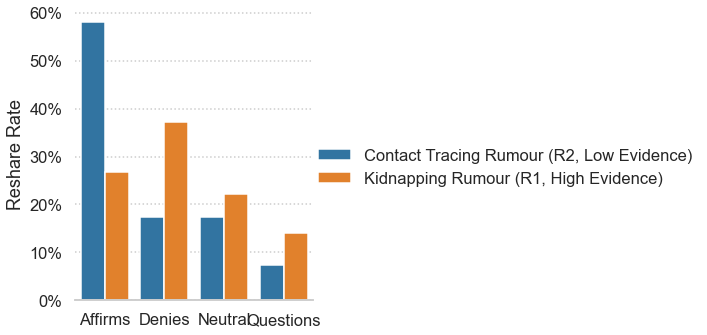

In [8]:
group_cols = ["rumour_label","code_label"]
# Get counts
reshare_rates = coded_tweets.groupby(group_cols)[['id']].count().rename({'id':'rate'},axis=1)
# convert to percentages
reshare_rates = reshare_rates.groupby(level=0).apply(lambda  x: x / float(x.sum())).reset_index()

from  matplotlib.ticker import PercentFormatter
g = sns.catplot(data=reshare_rates,
                kind="bar",
                x="code_label", 
                y="rate", 
                hue="rumour_label",
                ci="sd"
               )
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.despine(left=True)
g.set_axis_labels("", "Reshare Rate")
g.legend.set_title("")
g.savefig("../visualizations/reshare_rates.pdf")